#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [ ]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from sklearn.model_selection import GridSearchCV


RANDOM_STATE = 12345

In [ ]:
# Загружаем данные из файла в датафрейм

data = pd.read_csv('/datasets/taxi.csv')

In [ ]:
# Функция для вывода информации об изучаемых данных

def data_info(data):
    display(data.head(10))
    display(data.describe())
    print(data.info())
    print('Количество дубликатов:', sum(data.duplicated()))

In [ ]:
data_info(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
Количество дубликатов: 26415


In [ ]:
# Проверка пропущенных значений в каждом столбце
print(data.isna().sum())

num_orders    0
dtype: int64


In [ ]:
data.sort_index(inplace=True)

In [ ]:
# выполним ресемплирование

data_day = data.resample('1D').sum()
data = data.resample('1H').sum()


### Выводы

* Датасет состоит из 26496  строк и  2 столбцов
* В данных нет явных дубликатов и пропусков
* Были удалены пропуски и выполнено ресемплирование по одному часу

## Анализ

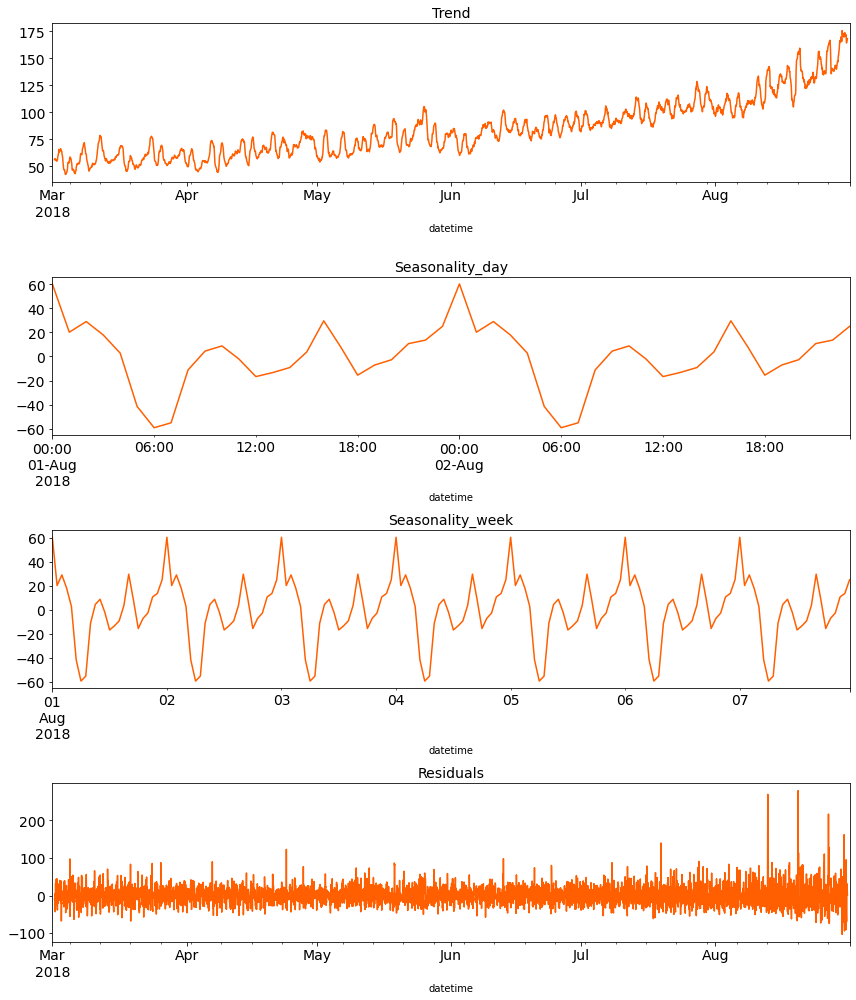

In [ ]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 14))

# Построим график тренда - плавное изменение среднего значения ряда
# без повторяющихся закономерностей
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca(), fontsize=14, color='#FF5F00')
plt.title(('Trend'), fontsize=14)

# Построим график сезонных изменений - циклично
# повторяющиеся закономерности во временном ряду
plt.subplot(412)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca(), fontsize=14, color='#FF5F00')
plt.title(('Seasonality_day'), fontsize=14)

# Построим график сезонных изменений - циклично
# повторяющиеся закономерности во временном ряду
plt.subplot(413)
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca(), fontsize=14, color='#FF5F00')
plt.title(('Seasonality_week'), fontsize=14)

#  Построим график шума - случайного изменения в ряду
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca(), fontsize=14, color='#FF5F00')
plt.title(('Residuals'), fontsize=14)

plt.tight_layout()

In [ ]:
# Построим график сезонных изменений - циклично
# повторяющиеся закономерности во временном ряду
decomposed_day = seasonal_decompose(data_day)



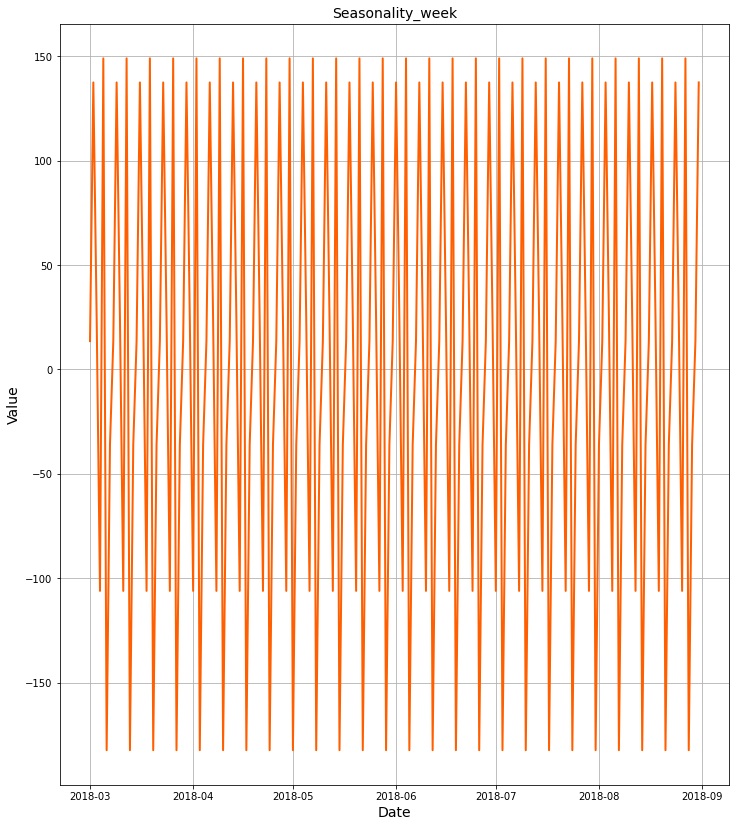

In [ ]:
plt.figure(figsize=(12, 14))
plt.plot(decomposed_day.seasonal.resample('D').mean(), color='#FF5F00', linewidth=2)
plt.title('Seasonality_week', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.grid(True)
plt.show()

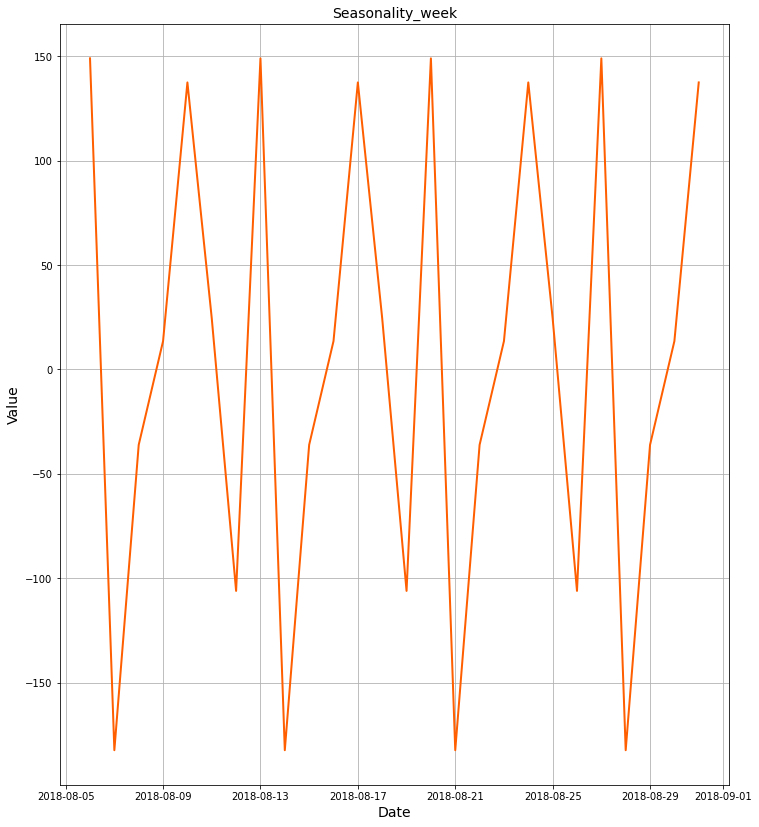

In [ ]:
plt.figure(figsize=(12, 14))

plt.plot(decomposed_day.seasonal['2018-08-06':'2018-09-03'].resample('D').mean(), color='#FF5F00', linewidth=2)
plt.title('Seasonality_week', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.grid(True)
plt.show()

### Выводы

Так как имеются данные только за 6 месяцев, то сложно пронаблюдать сезонность на больших промежутках времени.

График тренда (Trend) отображает плавное изменение среднего значения ряда без повторяющихся закономерностей. Тренд показывает общую тенденцию к возрастанию числа заказов в промежутке времени  с марта по август.

График дневной сезонности (Seasonality_day) отображает цикличные повторяющиеся закономерности в течение двух дней. и показывает в какие часы наблюдается наибольшее количество заказов и в какие часы их меньше. Количество заказов максимальное в полноч, к 6 утра достигает минимального количества.

График недельной сезонности (Seasonality_week) отображает цикличные повторяющиеся закономерности в течение недели. Наиболее успешные в плане количества заказов дни недели - понедельник и пятница.

### Формирование выборок

In [ ]:
def new_features(data, max_lag, rolling_mean_size):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
new_features(data, 24, 24)

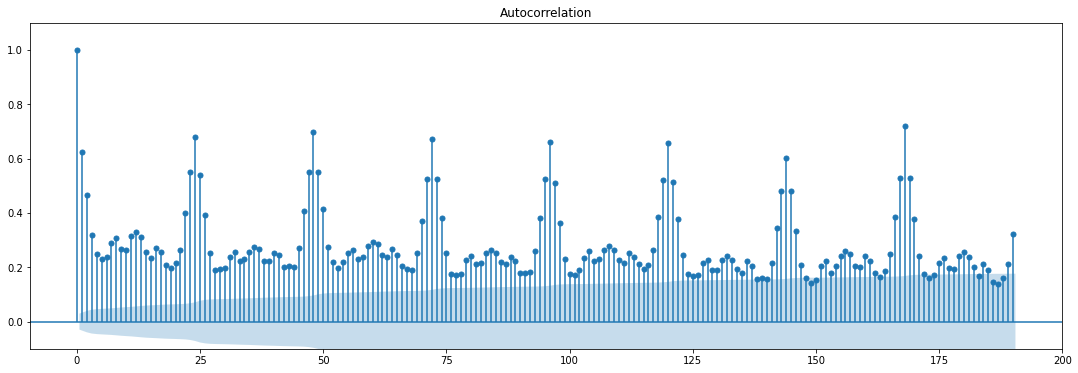

In [ ]:
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()


In [ ]:
# Данные разделим на тестовую и обучающую выборки

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [ ]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

In [ ]:
# Создадим датафрейм для результатов исследования

output = pd.DataFrame(columns=['Model_name', 'score'])

## Обучение

### LinearRegression

In [ ]:
%%time
# Кросс-валидация для оценки качества модели
cv = TimeSeriesSplit(n_splits=3).split(train_features)

model_LR = LinearRegression()

# Обучение модели
model_LR.fit(train_features, train_target)

# Оценка качества с использованием кросс-валидации
score_LR = cross_val_score(model_LR, train_features, train_target, scoring='neg_mean_squared_error', cv=cv)
score_LR = round(np.mean(-score_LR)**0.5, 2)

CPU times: user 151 ms, sys: 413 ms, total: 564 ms
Wall time: 504 ms


In [ ]:
# Добавим данные в датафрейм

output.loc[0, 'Model_name'] = 'LinearRegression'
output.loc[0, 'score'] = score_LR

### DecisionTreeRegressor

In [ ]:
# Подбор гиперпараметров с использованием и TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'max_depth': [None, 3, 5],
    'min_samples_leaf': [1, 3, 5]
}
model_DTR = DecisionTreeRegressor(random_state = RANDOM_STATE)
grid_search = GridSearchCV(model_DTR, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(train_features, train_target)

# Лучшие параметры модели
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)


Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 5}


In [ ]:
# Обучение модели с лучшими параметрами
model_DTR = DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                  min_samples_leaf=best_params['min_samples_leaf'],
                                  random_state=12345)
model_DTR.fit(train_features, train_target)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=12345)

In [ ]:
best_score = np.sqrt(-grid_search.best_score_)
print("Лучшее RMSE:", best_score)

Лучшее RMSE: 29.733091320197566


In [ ]:
# Оценка качества с использованием кросс-валидации
score_DTR = cross_val_score(model_DTR, train_features, train_target, scoring='neg_mean_squared_error', cv=tscv)
score_DTR = round(np.mean(-score_DTR)**0.5, 2)

In [ ]:
# Добавим занные в датафрейм output

output.loc[1, 'Model_name'] = 'DecisionTreeRegressor'
output.loc[1, 'score'] = score_DTR

### LGBMRegressor

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [6, 12, 18],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300]
}

model_LGBMR = LGBMRegressor(boosting_type='gbdt', random_state=12345)

grid_search = GridSearchCV(model_LGBMR, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(train_features, train_target)

# Лучшие параметры модели
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Обучение модели с лучшими параметрами
model_LGBMR = LGBMRegressor(boosting_type='gbdt', random_state=12345, **best_params)
model_LGBMR.fit(train_features, train_target)

# Оценка качества с использованием кросс-валидации
score_LGBMR = cross_val_score(model_LGBMR, train_features, train_target, scoring='neg_mean_squared_error', cv=tscv)
score_LGBMR = round(np.mean(-score_LGBMR)**0.5, 2)

In [ ]:
# Добавим занные в датафрейм output

output.loc[2, 'Model_name']='LGBMRegressor'
output.loc[2, 'score'] = score_LGBMR

### CatBoostRegressor

In [ ]:
# Подбор гиперпараметров с использованием TimeSeriesSplit и GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3]
}

model_catboost = CatBoostRegressor(loss_function='RMSE', silent=True)

grid_search = GridSearchCV(model_catboost, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(train_features, train_target)

# Лучшие параметры модели
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Обучение модели с лучшими параметрами
model_catboost = CatBoostRegressor(loss_function='RMSE', silent=True, **best_params)
model_catboost.fit(train_features, train_target)

# Оценка качества с использованием кросс-валидации
score_catboost = cross_val_score(model_catboost, train_features, train_target, scoring='neg_mean_squared_error', cv=tscv)
score_catboost = round(np.mean(-score_catboost)**0.5, 2)

Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 300}


In [ ]:
# Добавим занные в датафрейм output

output.loc[3, 'Model_name'] ='CatBoostRegressor'
output.loc[3, 'score'] = score_catboost

### RandomForestRegressor

In [ ]:
# Подбор гиперпараметров с использованием TimeSeriesSplit и GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [10, 15, 20]
}

model_RFR = RandomForestRegressor(random_state=12345)

grid_search = GridSearchCV(model_RFR, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(train_features, train_target)

# Лучшие параметры модели
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Обучение модели с лучшими параметрами
model_RFR = RandomForestRegressor(random_state=12345, **best_params)
model_RFR.fit(train_features, train_target)

# Оценка качества с использованием кросс-валидации
score_RFR = cross_val_score(model_RFR, train_features, train_target, scoring='neg_mean_squared_error', cv=tscv)
score_RFR = round(np.mean(-score_RFR)**0.5, 2)

Лучшие параметры: {'max_depth': 20, 'n_estimators': 100}


In [ ]:
# Добавим занные в датафрейм output

output.loc[4, 'Model_name']='RandomForestRegressor'
output.loc[4, 'score']=score_RFR

### Выводы

Построены модели LinearRegression, DecisionTreeRegressor, LGBMRegressor,  CatBoostRegressor, RandomForestRegressor.

In [ ]:
print(output.sort_values('score'))

              Model_name  score
3      CatBoostRegressor  24.62
4  RandomForestRegressor  25.51
0       LinearRegression  27.96
1  DecisionTreeRegressor  29.73


Лучшие результаты для модели DecisionTreeRegressor   (29.73). Немного хуже результаты для моделей LinearRegression     (27.96) и RandomForestRegressor    (25.51).

## Тестирование

In [ ]:
# Выбор финальной модели
final_model = model_DTR

# Прогноз на тестовой выборке
pred_test = final_model.predict(test_features)

# Оценка результатов
test_RMSE = np.sqrt(mean_squared_error(test_target, pred_test))
print("RMSE на тестовой выборке =", test_RMSE)

RMSE на тестовой выборке = 53.7536371228113


In [ ]:
# Создание прогноза предыдущим значением
pred_previous = test_target.shift()
pred_previous.iloc[0] = train_target.iloc[-1]

# Оценка RMSEпрогноза
baseline_RMSE = np.sqrt(mean_squared_error(test_target, pred_previous))
print("RMSE прогноза", baseline_RMSE)

# Сравнение RMSE модели с прогнозом
if test_RMSE < baseline_RMSE:
    print("Модель DecisionTreeRegressor   лучше базового прогноза")
else:
    print("Модель DecisionTreeRegressor   не лучше базового прогноза")

RMSE прогноза 58.856486242815066
Модель DecisionTreeRegressor   лучше базового прогноза


### Выводы

Для модели DecisionTreeRegressor   на тестовой выборке получено значение RMSE 53.75.

## Выводы

1. Датасет загружен, проанализирован, произведена предобработка данных:
    * Обработаны пропуски
    * Выполнено ресемплирование по одному часу
2. Обучены разные модели: LinearRegression, DecisionTreeRegressor, LGBMRegressor, CatBoostRegressor, RandomForestRegressor. Лучшие результаты для модели DecisionTreeRegressor (29.73). Немного хуже результаты для моделей LinearRegression (27.96) и RandomForestRegressor (25.51).
4. Качество лучшей модели проверено на тестовой выборке. Для модели DecisionTreeRegressor на тестовой выборке получено значение RMSE 53.75.